In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
from sklearn.cross_validation import train_test_split

import edward as ed
from edward.models import WishartFull, WishartCholesky, MultivariateNormalTriL, Empirical
from tensorflow.contrib.linalg import LinearOperatorTriL
ds = tf.contrib.distributions

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
D = 4
N = 10000
cov = np.array([[1, 0.2, 0.2, 0.2],[0.2, 2, 0.2, 0.2], [0.2, 0.2,3,0.2], [0.2,0.2,0.2,4]])
X = sps.multivariate_normal.rvs(mean = np.zeros(D), cov = cov, size=N)

In [12]:
X.mean(axis=0)

array([ 0.02035888,  0.00507184, -0.00623285, -0.02257487])

In [13]:
np.cov(X.T)

array([[ 0.99877968,  0.19501715,  0.20255285,  0.13835885],
       [ 0.19501715,  2.01261039,  0.19953566,  0.18842699],
       [ 0.20255285,  0.19953566,  3.00268863,  0.19780642],
       [ 0.13835885,  0.18842699,  0.19780642,  3.93739847]])

## probabilistic model

In [14]:
# priors
v_prior = tf.Variable(D**2, dtype=tf.float32, trainable=False)
W_prior = tf.Variable(np.eye(D),
                      dtype=tf.float32, trainable=False)
m_prior = tf.Variable(np.zeros(D), dtype=tf.float32, trainable=False)
k_prior = tf.Variable(1., dtype=tf.float32, trainable=False)

In [15]:
#sigma = WishartCholesky(df=v_prior, scale=W_prior,cholesky_input_output_matrices=True, name="psigma")
sigma = WishartFull(df=v_prior, scale=W_prior, name="psigma")
mu = MultivariateNormalTriL(m_prior, k_prior * sigma)
xn = MultivariateNormalTriL(tf.reshape(tf.tile(mu, [N]), [N, D]),
                            tf.reshape(tf.tile(sigma, [N, 1]), [N, D, D]))

In [16]:
print('***** PROBABILISTIC MODEL *****')
print('mu: {}'.format(mu))
print('sigma: {}'.format(sigma))
print('xn: {}'.format(xn))

***** PROBABILISTIC MODEL *****
mu: RandomVariable("MultivariateNormalTriL_3/", shape=(4,), dtype=float32)
sigma: RandomVariable("psigma/", shape=(4, 4), dtype=float32)
xn: RandomVariable("MultivariateNormalTriL_7/", shape=(10000, 4), dtype=float32)


## variational model

In [17]:
ds = tf.contrib.distributions

It seems that the Cholesky factor doesn't need positive elements in the diagonal. But let's do it anyway.

In [18]:
m = tf.Variable(tf.random_normal([D], dtype=tf.float32))
R = tf.Variable(tf.random_normal([D, D], dtype=tf.float32))
qmu = MultivariateNormalTriL(m, ds.matrix_diag_transform(R, transform=tf.nn.softplus))

L = tf.Variable(tf.random_normal([D, D], dtype=tf.float32))
Ltril = LinearOperatorTriL(ds.matrix_diag_transform(L, transform=tf.nn.softplus)).to_dense()
qsigma = WishartCholesky(tf.nn.softplus(tf.Variable(tf.random_normal([], dtype=tf.float32))+D+100),
    Ltril, name="qsigma")#,cholesky_input_output_matrices=True)

In [19]:
inference3 = ed.KLqp({mu: qmu, sigma: qsigma}, data={xn: X})
inference3.initialize(n_iter=600, n_print=100, n_samples=40)

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

{'t': 1, 'loss': 236281.56}
{'t': 101, 'loss': 73617.594}
{'t': 201, 'loss': 73520.82}
{'t': 301, 'loss': 73591.859}
{'t': 401, 'loss': 73525.773}
{'t': 501, 'loss': 73469.852}


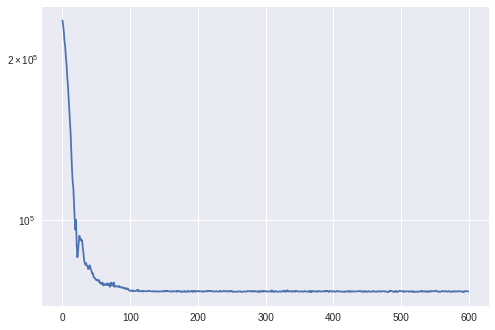

In [20]:
learning_curve3 = []
for _ in range(inference3.n_iter):
    info_dict = inference3.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve3.append(info_dict['loss'])
plt.semilogy(learning_curve3)

In [21]:
qmu.mean().eval()

array([ 0.02149469,  0.00353608, -0.01490306, -0.02743007], dtype=float32)

In [22]:
qsigma.mode().eval()

array([[ 1.00010717,  0.24549128,  0.27485895,  0.17429754],
       [ 0.24549128,  1.42427623,  0.11028795,  0.09771474],
       [ 0.27485895,  0.11028795,  1.75238693,  0.01273486],
       [ 0.17429754,  0.09771474,  0.01273486,  1.92086792]], dtype=float32)

In [27]:
np.linalg.norm(cov-qsigma.mode().eval())/np.linalg.norm(cov)

0.4558820817553299

In [28]:
covmats = qsigma.sample(10000).eval()

In [29]:
import itertools

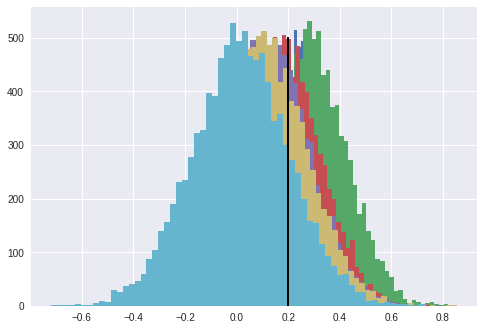

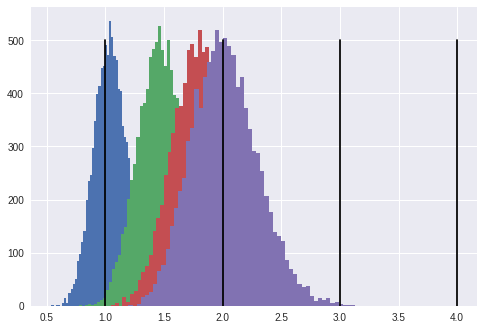

In [30]:
for i, j in itertools.combinations(range(D),2):
    # covariances
    plt.hist(covmats[:,i,j],'auto');
    plt.plot((cov[i,j], cov[i,j]), (0, 500), 'k-')
plt.figure()
for i in range(D):
    # variances
    plt.hist(covmats[:,i,i],'auto');
    plt.plot((cov[i,i], cov[i,i]), (0, 500), 'k-')